# GO_cluster

# 輸入檔案

In [2]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 讀取 CSV 文件
 
file_path = "../result/GSE243529/train75/distance_matrix_0.01.csv" # example
output_file_path = "../result/GSE243529/train75/cluster_0.01.csv" # example

file_path = '../breast/result/GSE243529/train50/similarity_matrix_hyper_tss_0.02.csv'
output_file_path = '../breast/result/GSE243529/train50/cluster_hyper_tss_0.02_4_group.csv'

## *如果輸入為相似度矩陣

In [3]:
similarity_matrix = pd.read_csv(file_path, index_col=0)  # 假設 CSV 文件中第一列是索引

distance_matrix = 1 - similarity_matrix

## * 如果輸入為距離矩陣

In [ ]:
distance_matrix = pd.read_csv(file_path, index_col=0)  # 假設 CSV 文件中第一列是索引

## 查看轉換後的距離矩陣

In [4]:
# 查看轉換後的距離矩陣
print(distance_matrix)


dis_col = distance_matrix # 保存column_name

        ACACA  ACADM  ACOT7  ADAM10  ADAM12  ADIPOR1    ADK  AKAP1   AKT1  \
ACACA   0.000  0.480  0.461   0.480   0.393    0.338  0.473  0.436  0.478   
ACADM   0.480  0.000  0.599   0.636   0.633    0.560  0.720  0.569  0.580   
ACOT7   0.461  0.599  0.000   0.508   0.538    0.524  0.699  0.522  0.523   
ADAM10  0.480  0.636  0.508   0.000   0.165    0.422  0.727  0.541  0.485   
ADAM12  0.393  0.633  0.538   0.165   0.000    0.390  0.646  0.470  0.543   
...       ...    ...    ...     ...     ...      ...    ...    ...    ...   
ZNF687  0.313  0.601  0.555   0.480   0.347    0.326  0.475  0.266  0.574   
KLHL35  0.000  0.212  0.000   0.000   0.000    0.000  0.643  0.000  0.000   
NT5DC2  0.569  0.804  0.751   0.688   0.547    0.625  0.630  0.755  0.802   
PHF21B  0.000  0.729  0.643   0.000   0.000    0.000  0.000  0.643  0.613   
ZNF583  0.561  0.809  0.811   0.725   0.586    0.616  0.568  0.668  0.809   

         AKT3  ...  CRISP2  FAM163A  FNDC3B  KIAA0513   TSKS  ZNF687  KLHL3

##  確認 matrix file  

+ 是否大小對稱 ? 大小 ?
+ 是否對角線元素為0
+ 多少NaN 值

In [5]:
import numpy as np

is_square = distance_matrix.shape[0] == distance_matrix.shape[1]
print("Matrix is square:", is_square)

diagonal_elements = np.diag(distance_matrix)
are_diagonals_zero = np.all(diagonal_elements == 0)
print("All diagonal elements are zero:", are_diagonals_zero)

nan_count = distance_matrix.isna().sum().sum()
print("Number of NaN values in the matrix:", nan_count)


Matrix is square: True
All diagonal elements are zero: True
Number of NaN values in the matrix: 116


## 將NaN 值改為 1，對角線值改為0

In [6]:

distance_matrix = distance_matrix.fillna(1)
# distance_matrix[distance_matrix == 0] = 1

distance_matrix = distance_matrix.values
np.fill_diagonal(distance_matrix, 0)


len(distance_matrix)

385

## 進行分群 與 輪廓係數 圖

Best number of clusters: 6


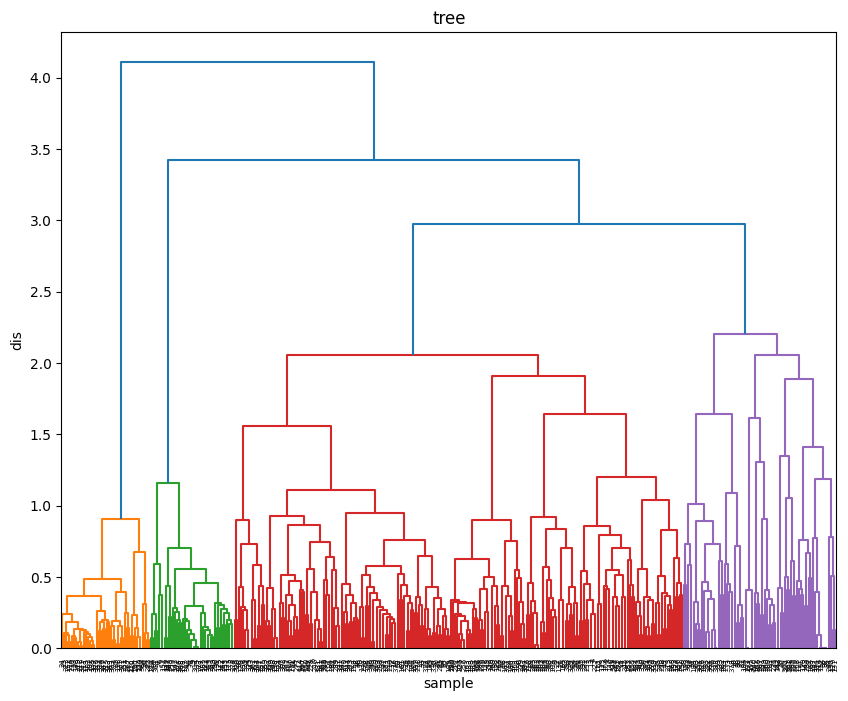

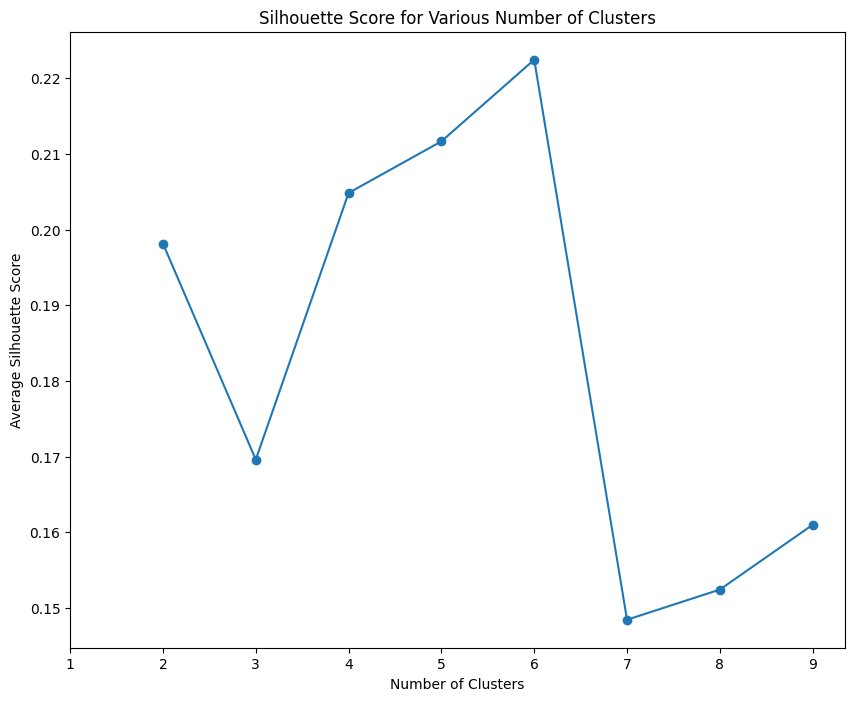

In [7]:
from scipy.spatial.distance import squareform



condensed_matrix = squareform(distance_matrix)

Z = linkage(condensed_matrix, method='ward')

plt.figure(figsize=(10, 8))
dendrogram(Z,color_threshold=Z[-3, 2]) # => color_threshold=Z[-3, 2] 可更改染色範圍，可因應需求更改
plt.title('tree')
plt.xlabel('sample')
plt.ylabel('dis')

# 設定不同的分群數範圍
range_n_clusters = list(range(2, 10)) # 2~10 群
 
silhouette_avg = []

# 計算不同分群數的輪廓係數
for n_clusters in range_n_clusters:
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    silhouette_avg.append(silhouette_score(distance_matrix, labels, metric='precomputed'))

# 找到輪廓係數最高的分群數
best_n_clusters = range_n_clusters[np.argmax(silhouette_avg)]
print("Best number of clusters:", best_n_clusters)


plt.figure(figsize=(10, 8))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette Score for Various Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
# plt.xlim(0, 10)
plt.xticks(range(1, 10, 1))
plt.show()

## 確認分群數目

In [8]:
n_clusters = 4

## 輸出檔案

In [9]:
labels = fcluster(Z, n_clusters, criterion='maxclust')

# 獲取基因名稱
gene_names = dis_col.columns 

gene_clusters = pd.DataFrame({
    'gene': gene_names,
    'cluster': labels
})

# 保存分群結果到 CSV 文件
gene_clusters.to_csv(output_file_path, index=False)

print("分群结果已保存至:", output_file_path)
print(gene_clusters.head())

分群结果已保存至: ../breast/result/GSE243529/train50/cluster_hyper_tss_0.02_4_group.csv
     gene  cluster
0   ACACA        3
1   ACADM        4
2   ACOT7        3
3  ADAM10        3
4  ADAM12        3
